# Three bird classifier attempt
This file contains a first attempt of training a three bird classifier

In [1]:
# Deep Learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

# Audio processing
import torchaudio
import torchaudio.transforms as T
import librosa

# Pre-trained image models
import timm

# Others
import os
import pandas as pd
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [14]:
root_dir = 'data/audio/'
class_names = ['galerida_cristata', 'picus_viridis', 'phasianus_colchicus']
files_df = pd.DataFrame(columns=['file_path', 'target'])

In [15]:
for class_name in class_names:
    files_path = os.path.join(root_dir, class_name)
    file_paths = [os.path.join(files_path, file) for file in os.listdir(files_path)]
    
    df = pd.DataFrame(file_paths, columns=['file_path'])
    df['target'] = class_name
    
    files_df = pd.concat([files_df, df], ignore_index=True)

In [16]:
files_df

,file_path,target
0,data/audio/galerida_cristata/XC676678 - Creste...,galerida_cristata
1,data/audio/galerida_cristata/XC643767 - Creste...,galerida_cristata
2,data/audio/galerida_cristata/XC781592 - Creste...,galerida_cristata
3,data/audio/galerida_cristata/XC343817 - Creste...,galerida_cristata
4,data/audio/galerida_cristata/XC397203 - Creste...,galerida_cristata
...,...,...
457,data/audio/phasianus_colchicus/XC685640 - Comm...,phasianus_colchicus
458,data/audio/phasianus_colchicus/XC509327 - Comm...,phasianus_colchicus
459,data/audio/phasianus_colchicus/XC706417 - Comm...,phasianus_colchicus
460,data/audio/phasianus_colchicus/XC441882 - Comm...,phasianus_colchicus


In [5]:
# PATH = "data/audio/picus_viridis/XC541541 - European Green Woodpecker - Picus viridis.mp3"

PATH = "data/recordings/ogg_files/1_041_209/20230107_213000.ogg"

# Load a sample audio file with librosa
original_audio, sample_rate = librosa.load(PATH, sr=None, offset=(41*60)+25, duration=5)

print(original_audio.shape)

audio = torch.tensor(original_audio)

if sample_rate != 32000:
    resample = T.Resample(sample_rate, 32000)
    audio = resample(audio)

melspectrogram = T.MelSpectrogram(sample_rate = 32000, 
                                        n_mels = 64, 
                                        n_fft = 2048, 
                                        hop_length = 512)
melspec = melspectrogram(audio)

melspec_stack = torch.stack([melspec])

(160000,)


In [40]:
# Load a sample audio file with torchaudio
original_audio, sample_rate = torchaudio.load(PATH, format="MP3")

RuntimeError: Failed to load audio from data/audio/picus_viridis/XC541541 - European Green Woodpecker - Picus viridis.mp3

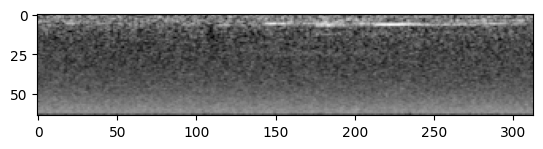

In [6]:
plt.figure()
plt.imshow(melspec_stack.log2()[0,:,:].numpy(), cmap='gray')

In [27]:
class AudioDataset(Dataset):
    def __init__(self, 
                df, 
                target_sample_rate=32000, 
                audio_length=5,
                wave_transforms=None,
                spec_transforms=None):
        self.df = df
        self.file_paths = df['file_path'].values
        self.labels = df['target'].values
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * audio_length
        self.wave_transforms = wave_transforms
        self.spec_transforms = spec_transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        # Load audio from file to waveform
        # audio, sample_rate = torchaudio.load(self.file_paths[index])
        
        # Limit the audio duration to 5 seconds for now. We want to cut larger files into 5 seconds
        # segments and use them all in a later version
        audio, sample_rate = librosa.load(self.file_paths[index], sr=None, duration=audio_length)
        
        audio = torch.tensor(audio)

        # Convert to mono
        # audio = torch.mean(audio, axis=0)

        # Resample
        if sample_rate != self.target_sample_rate:
            resample = T.Resample(sample_rate, self.target_sample_rate)
            audio = resample(audio)
        
        # Adjust number of samples
        if audio.shape[0] > self.num_samples:
            # Crop
            audio = audio[:self.num_samples]
        elif audio.shape[0] < self.num_samples:
            # Pad
            audio = F.pad(audio, (0, self.num_samples - audio.shape[0]))


        # Add any preprocessing you like here 
        # (e.g., converting to mono, resampling, adjusting size, noise removal, etc.)
        
        # Add any data augmentations for waveform you like here
        # (e.g., noise injection, shifting time, changing speed and pitch)
        wave_transforms = T.PitchShift(sample_rate, 4)
        audio = wave_transforms(audio)

        # Convert to Mel spectrogram
        melspectrogram = T.MelSpectrogram(sample_rate = self.target_sample_rate, 
                                        n_mels = 128, 
                                        n_fft = 2048, 
                                        hop_length = 512)
        melspec = melspectrogram(audio)
        
        # Add any data augmentations for spectrogram you like here
        # (e.g., Mixup, cutmix, time masking, frequency masking)
        spec_transforms = T.FrequencyMasking(freq_mask_param=80)
        melspec = spec_transforms(melspec)
        
        return {"image": torch.stack([melspec]), 
                "label": torch.tensor(self.labels[index]).float()}

In [18]:
class AudioModel(nn.Module):
    def __init__(self, 
                model_name = 'tf_efficientnet_b3_ns',
                pretrained = True, 
                num_classes = None):
        super(AudioModel, self).__init__()

        self.model = timm.create_model(model_name, 
                                       pretrained = pretrained, 
                                       in_chans = 1)
        self.in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
              nn.Linear(self.in_features, num_classes)
          )

    def forward(self, images):
        logits = self.model(images)
        return logits

In [26]:
dataset = AudioDataset(files_df)
training_data, test_data = random_split(dataset, [0.7, 0.3])

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)